In [43]:
!pip install numpy


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
!pip install tensorflow


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Importing Libraries

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint,EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras import models
from keras import layers
from tensorflow.python.client import device_lib 


# My Dataset path

In [3]:
dataset_path = r"data2/"
print(dataset_path)


data2/


# My class labels

In [5]:
dataset = image_dataset_from_directory(dataset_path,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(224,224),color_mode='rgb',label_mode= 'categorical',
                                             class_names=classes,
                                             seed=123,
                                       )

Found 3081 files belonging to 33 classes.


# Data distribution
Spliting data into testing, validation and training at the ration of 70:30

In [12]:
# compute the cardinality (number of elements) of a tf.data.Dataset
tf.data.experimental.cardinality(dataset)

<tf.Tensor: shape=(), dtype=int64, numpy=97>

In [15]:
dataset_batches = tf.data.experimental.cardinality(dataset)
validation_dataset = dataset.take(dataset_batches // 7)
training_dataset = dataset.skip(dataset_batches // 7) 



In [16]:
# Split the Validation to valid and test
val_batches = tf.data.experimental.cardinality(validation_dataset)
testing_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)


In [17]:
# To Increase up Feeding Data To Network
AUTOTUNE = tf.data.AUTOTUNE
training_dataset = training_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
testing_dataset = testing_dataset.prefetch(buffer_size=AUTOTUNE)

In [18]:
# Display The No. of Batches 
print(tf.data.experimental.cardinality(training_dataset))
print(tf.data.experimental.cardinality(validation_dataset))
print(tf.data.experimental.cardinality(testing_dataset))

tf.Tensor(84, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)


In [19]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Brightness and Contrast Layer


In [20]:
class RandomColorDistortion(tf.keras.layers.Layer):
    def __init__(self, contrast_range=[0.6, 1.8], 
                 brightness_delta=[-0.3, 0.3], **kwargs):
        super(RandomColorDistortion, self).__init__(**kwargs)
        self.contrast_range = contrast_range
        self.brightness_delta = brightness_delta
    
    def call(self, images, training=True):
        if not training:
            return images
        
        contrast = np.random.uniform(
            self.contrast_range[0], self.contrast_range[1])
        brightness = np.random.uniform(
            self.brightness_delta[0], self.brightness_delta[1])
        
        images = tf.image.adjust_contrast(images, contrast)
        images = tf.image.adjust_brightness(images, brightness)
        images = tf.clip_by_value(images, 0, 255)
        return images

# Data Augmentation Layer

In [21]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.05),
    tf.keras.layers.RandomWidth((-.2,.2), interpolation='bilinear'),
    tf.keras.layers.RandomHeight((-.2,.2), interpolation='bilinear'),
    tf.keras.layers.RandomTranslation((-0.1, 0.1),(-0.1, 0.1),fill_mode='constant'),
    tf.keras.layers.Resizing(224,224,interpolation='bilinear'),
    RandomColorDistortion()
])

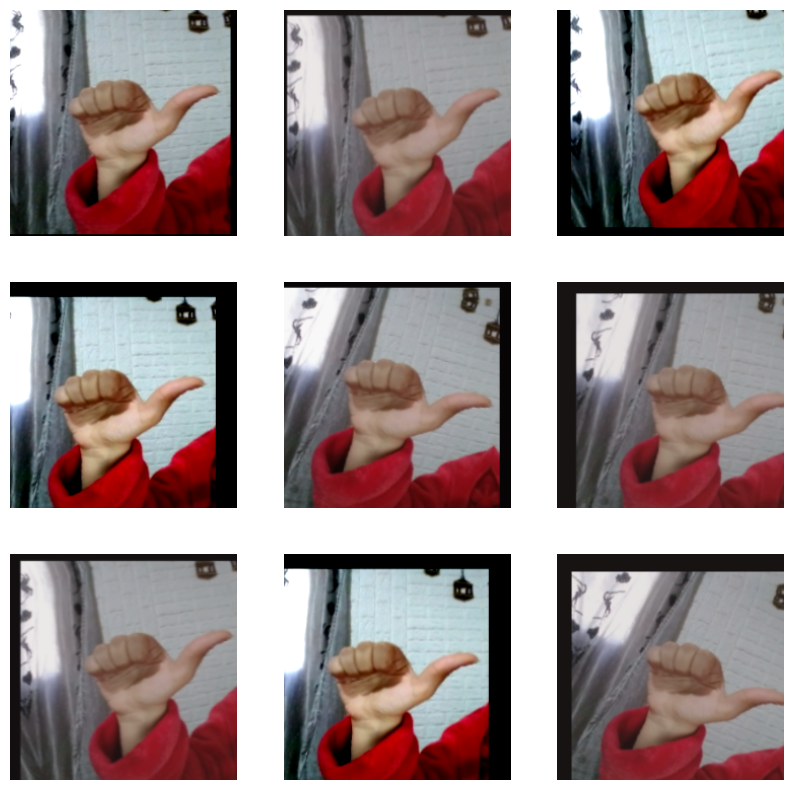

In [38]:
for image, _ in training_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))

    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [23]:
BATCH_SIZE = 32
IMG_SIZE = (224,224)

# Model VGG16

In [40]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

# Transfer Learning
Applying transfer learning to get better performance

In [25]:
# Applying Transfer learning
conv_base.trainable = False

# Build Network for Training 

In [26]:
inp = layers.Input(shape=(224,224,3))
x = data_augmentation(inp)
x = (conv_base)(inp)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outs = layers.Dense(len(classes), activation='softmax')(x)
model = models.Model(inputs=inp, outputs=[outs])

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 33)                4257      
                                                                 
Total params: 17930337 (68.40 MB)
Trainable params: 3215649 (12.27 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


# Compiling Model

In [28]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

In [29]:
log_dir = os.path.join('Logs/vgg16_transfer_learning')
tb_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,
                          update_freq='epoch',
                          profile_batch=0) ## !tensorboard --logdir=.
mc = ModelCheckpoint('Models/vgg16_transfer_learning.h5', monitor='val_acc', mode='max', verbose=1,save_best_only=True)
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1,patience=5)
callbacks = [tb_callback,mc,es]

# Training Model

In [30]:
model.fit(training_dataset,epochs=5,callbacks=[callbacks], validation_data = validation_dataset)

Epoch 1/5
84/84 [==============================] - ETA: 0s - loss: 10.5702 - acc: 0.0964
Epoch 1: val_acc improved from -inf to 0.19196, saving model to Models\vgg16_transfer_learning.h5
84/84 [==============================] - 794s 9s/step - loss: 10.5702 - acc: 0.0964 - val_loss: 5.8752 - val_acc: 0.1920
Epoch 2/5


C:\Users\SYSTEMS_ENGINEER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


84/84 [==============================] - ETA: 0s - loss: 4.3231 - acc: 0.2664
Epoch 2: val_acc improved from 0.19196 to 0.26786, saving model to Models\vgg16_transfer_learning.h5
84/84 [==============================] - 745s 9s/step - loss: 4.3231 - acc: 0.2664 - val_loss: 4.2281 - val_acc: 0.2679
Epoch 3/5
84/84 [==============================] - ETA: 0s - loss: 2.4421 - acc: 0.4544
Epoch 3: val_acc improved from 0.26786 to 0.36607, saving model to Models\vgg16_transfer_learning.h5
84/84 [==============================] - 740s 9s/step - loss: 2.4421 - acc: 0.4544 - val_loss: 3.1287 - val_acc: 0.3661
Epoch 4/5
84/84 [==============================] - ETA: 0s - loss: 1.4071 - acc: 0.6525
Epoch 4: val_acc improved from 0.36607 to 0.47321, saving model to Models\vgg16_transfer_learning.h5
84/84 [==============================] - 732s 9s/step - loss: 1.4071 - acc: 0.6525 - val_loss: 2.8757 - val_acc: 0.4732
Epoch 5/5
84/84 [==============================] - ETA: 0s - loss: 0.8273 - acc: 0.

In [32]:
# Save The Last Model
model.save('arabic_sign_language_model.h5')

In [33]:
model = tf.keras.models.load_model('arabic_sign_language_model.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('arabic_sign_language_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\SYSTEM~1\AppData\Local\Temp\tmpubdle879\assets


INFO:tensorflow:Assets written to: C:\Users\SYSTEM~1\AppData\Local\Temp\tmpubdle879\assets


In [34]:
model.evaluate(testing_dataset) 

6/6 [==============================] - 55s 8s/step - loss: 2.4706 - acc: 0.4844


[2.470576047897339, 0.484375]

In [ ]:
{
'Aasif': 0,
'Akhi': 1,
'Asmak': 2,
'Ayna': 3,
'Ab': 4,
'Ibn': 5,
'Ibnah': 6,
'Ijtima': 7,
'Ukht': 8,
'Usbu': 9,
'Al-ithnayn': 10,
'Al-ahad': 11,
'Al-arba': 12,
'Al-thulatha': 13,
'Al-jumua': 14,
'Al-khamees': 15,
'As-saa': 16,
'As-sabt': 17,
'Al-makan': 18,
'Al-yawm': 19,
'Um': 20,
'Ams': 21,
'Ana': 22,
'Ana bikheir': 23,
'Anta': 24,
'Email': 25,
'Bukra': 26,
'Bint': 27,
'Bayt': 28,
'Taskun': 29,
'Taamal': 30,
'Jadd': 31,
'Jaddah': 32,
'Jayyid': 33,
'Khaal': 34,
'Khaalah': 35,
'Daftar': 36,
'Raee': 37,
'Sanah': 38,
'Sayyi': 39,
'Shahr': 40,
'Tifl': 41,
'Tifl radhi': 42,
'Amal jayyid': 43,
'Ghayr muhim': 44,
'Kam': 45,
'Law samaht': 46,
'Ma': 47,
'Makanak': 48,
'Muhim': 49,
'Hatha raheeb': 50,
'Walad': 51
}